In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats

In [2]:
dataFile = r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_20_50_10.csv'

In [3]:
myData = pd.read_csv(dataFile)

### Add useful transformations

In [4]:
# add physical time based on DHB length
myData['age_track'] = (myData.DHB_len - 1) *10 / 60

In [5]:
# add day of experiments (with 'd' because otherwise seaborn fails to recognize it as a category)
myData['day']=[f"d{x.split('_')[0]}" for x in myData.file]
myData = myData.astype({"day": 'object'})
set(myData['day'])

{'d20190506',
 'd20190607',
 'd20190609',
 'd20190625',
 'd20190701',
 'd201907012',
 'd201907016'}

In [6]:
myData.head()

,Unnamed: 0,Unnamed: 0.1,file,original cell name,Amy_mod,movie,x,y,ab1 (heterochromatin),ab1 ch,...,hetChrom_10_volume,random_10_volume,hetChrom_10perc_ch1,random_10perc_ch1,hetChrom_10perc_ch2,random_10perc_ch2,hetChrom_10perc_ch3,random_10perc_ch3,age_track,day
0,0,0,20190625_cell-00.czi,7LE1(B),1130/10,190619-cdc6-dhb-pcna002xy09,172,956,HP1B,1,...,45987.0,46247.0,6.366278e+08,281528813.0,174067475.0,131640512.0,1.352231e+09,1.043517e+09,0.666667,d20190625
1,1,1,20190625_cell-01.czi,7L-E1(T),0,190619-cdc6-dhb-pcna002xy09,158,906,HP1B,1,...,43651.0,43924.0,5.861875e+08,266516067.0,162411790.0,128299406.0,1.353023e+09,1.065184e+09,0.666667,d20190625
2,2,2,20190625_cell-02.czi,7L-E2(B),0,190619-cdc6-dhb-pcna002xy09,832,252,HP1B,1,...,39698.0,39812.0,6.928624e+08,318905411.0,194622718.0,148176740.0,1.366670e+09,1.118365e+09,2.000000,d20190625
3,3,3,20190625_cell-03.czi,7L-E2(T),0,190619-cdc6-dhb-pcna002xy09,888,160,HP1B,1,...,42159.0,41848.0,6.473978e+08,285348983.0,195376713.0,139563277.0,1.298882e+09,1.038559e+09,2.000000,d20190625
4,4,4,20190625_cell-05.czi,7L-G2,0,190619-cdc6-dhb-pcna002xy09,172,324,HP1B,1,...,81411.0,81271.0,1.506281e+09,698512214.0,248463390.0,183210463.0,2.583220e+09,2.158853e+09,19.500000,d20190625


### Molecular age modification

We ran into a problem where younger cells (with low physical age and in category of 'earlyG1') having higher molecular age, which were therefore influencing our regression model. 

Initially, we assigned those cells' molecular age to '0.3'.

In [21]:
#myDataSel=myData.loc[((myData.decon==True) & (myData['ab1 (heterochromatin)']=='HP1B')),:].copy()
#myDataSel['mol_age_mod']=myDataSel.molecularAge_ratio
#myDataSel.loc[((myDataSel.age_track<1.5) & (myDataSel.category=='earlyG1')),'mol_age_mod']=0.3

In [8]:
#myDataSelnd=myData.loc[((myData.decon==False) & (myData['ab1 (heterochromatin)']=='HP1B')),:].copy()
#myDataSelnd['mol_age_mod']=myDataSelnd.molecularAge_ratio
#myDataSelnd.loc[((myDataSelnd.age_track<1.5) & (myDataSelnd.category=='earlyG1')),'mol_age_mod']=0.3

However, after the thought that an arbitrary number is most likely still influencing our final model, we wanted to come up with a solution where these molecular ages can be reassigned according to their original values. 

So, here I identify the cells and its molecular age; then *multiply -1* (this allows me to re-order the cells in the way we want - since the 'higher molecular age' amongst these cells actually mean 'younger cells'). Since the negative age would not make sense, I *added the max molecular age* to these negative numbers, making them positive and to be placed in order.  

In [76]:
myDataSel=myData.loc[((myData.decon==True) & (myData['ab1 (heterochromatin)']=='HP1B')),:].copy()
myDataSel['mol_age_mod']=myDataSel.molecularAge_ratio
myDataSel_mol_age_change=myDataSel.loc[((myDataSel.age_track<1.5) & (myDataSel.category=='earlyG1')),'mol_age_mod']
myDataSel.loc[((myDataSel.age_track<1.5) & (myDataSel.category=='earlyG1')),'mol_age_mod']=-1*myDataSel['mol_age_mod']+np.max(myDataSel_mol_age_change)

In [107]:
myDataSelnd=myData.loc[((myData.decon==False) & (myData['ab1 (heterochromatin)']=='HP1B')),:].copy()
myDataSelnd['mol_age_mod']=myDataSelnd.molecularAge_ratio
myDataSelnd_mol_age_change=myDataSelnd.loc[((myDataSelnd.age_track<1.5) & (myDataSelnd.category=='earlyG1')),'mol_age_mod']
myDataSelnd.loc[((myDataSelnd.age_track<1.5) & (myDataSelnd.category=='earlyG1')),'mol_age_mod']=-1*myDataSelnd['mol_age_mod']+np.max(myDataSelnd_mol_age_change)

##### note - on molecular age modification
This modification does make the selected molecular ages to be reordered in the way we want - but the values may not necessarily match with the overall molecular age of earlyG1 since the lowest value (excluding the selected cells) is 0.3 . If the lowest molecular age cannot be 0, use this code:

In [112]:
'''
myDataSel_eG1_molAge_nonsel=myDataSel.loc[(myDataSel.category=='earlyG1') & (myDataSel.age_track>1.5),'mol_age_mod']
addon=np.min(myDataSel_eG1_molAge_nonsel)
myDataSel.loc[((myDataSel.age_track<1.5) & (myDataSel.category=='earlyG1') & 
                 (myDataSel.mol_age_mod < np.min(myDataSel_eG1_molAge_nonsel))),'mol_age_mod'] = myDataSel.mol_age_mod+addon
myDataSelnd_eG1_molAge_nonsel=myDataSelnd.loc[(myDataSelnd.category=='earlyG1') & (myDataSelnd.age_track>1.5),'mol_age_mod']
addon=np.min(myDataSelnd_eG1_molAge_nonsel)
myDataSelnd.loc[((myDataSelnd.age_track<1.5) & (myDataSelnd.category=='earlyG1') & 
                 (myDataSelnd.mol_age_mod < np.min(myDataSelnd_eG1_molAge_nonsel))),'mol_age_mod'] = myDataSelnd.mol_age_mod+addon
'''

## gestalt

### deconvoled gestalt

<IPython.core.display.Javascript object>


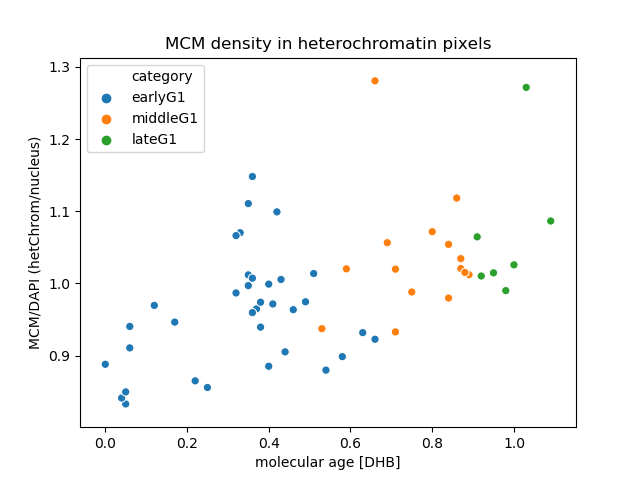

Text(0.5, 1.0, 'MCM density in heterochromatin pixels')

In [113]:
%matplotlib notebook

myDataSel['temp']=(myDataSel.hetChrom_gestalt_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_gestalt_ch3/myDataSel.nucleus_Otsu_ch3)
sn.scatterplot(x='mol_age_mod', y = 'temp', data=myDataSel.loc[((myDataSel.day!='d20190625') & (myDataSel.day!='d201907012') &
                                                           ['G1' in x for x in myDataSel.category]),:],hue='category')
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
plt.title("MCM density in heterochromatin pixels")

<IPython.core.display.Javascript object>


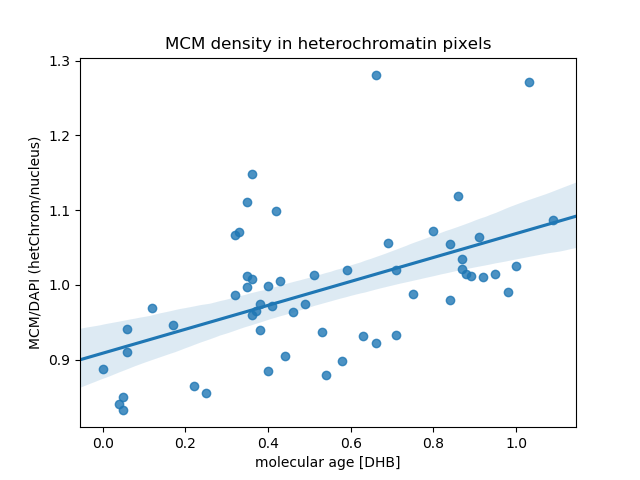

In [79]:
%matplotlib notebook

myDataSel['temp']=(myDataSel.hetChrom_gestalt_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_gestalt_ch3/myDataSel.nucleus_Otsu_ch3)
sn.regplot(x='mol_age_mod', y = 'temp', data=myDataSel.loc[((myDataSel.day!='d20190625') & (myDataSel.day!='d201907012') &
                                                           ['G1' in x for x in myDataSel.category]),:])
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
x=plt.title("MCM density in heterochromatin pixels")

In [80]:
# temp = (myDataSel.hetChrom_gestalt_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_gestalt_ch3/myDataSel.nucleus_Otsu_ch3)
x = np.array(myDataSel.mol_age_mod)
y = np.array(myDataSel.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.07304172662880891, intercept=0.96903878463067, rvalue=0.2263039275803349, pvalue=0.013330252034600273, stderr=0.029064995791207984)

to avoid the influence of setting the number to 0.3, we try to subtract 0.4 to spread out the selected data accordingly. 

however, the problem is that the younger cells are now treated older than the original older cells.

In [32]:
# temp = (myDataSel.hetChrom_gestalt_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_gestalt_ch3/myDataSel.nucleus_Otsu_ch3)
x = np.array(myDataSel.mol_age_mod)
y = np.array(myDataSel.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.07031849894201672, intercept=0.9698245026112778, rvalue=0.20710110321035255, pvalue=0.023826228982094643, stderr=0.030709657896813486)

### not deconvolved 

<IPython.core.display.Javascript object>


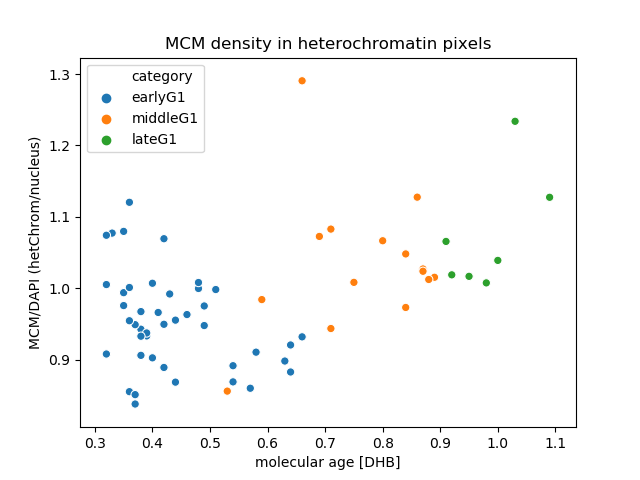

Text(0.5, 1.0, 'MCM density in heterochromatin pixels')

In [114]:
%matplotlib notebook

myDataSelnd['temp']=(myDataSelnd.hetChrom_gestalt_ch2/myDataSelnd.nucleus_Otsu_ch2)/(myDataSelnd.hetChrom_gestalt_ch3/myDataSelnd.nucleus_Otsu_ch3)
sn.scatterplot(x='mol_age_mod', y = 'temp', data=myDataSelnd.loc[((myDataSelnd.day!='d20190625') & (myDataSelnd.day!='d201907012') &
                                                           ['G1' in x for x in myDataSelnd.category]),:],hue='category')
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
plt.title("MCM density in heterochromatin pixels")

In [83]:
# temp=(myDataSelnd.hetChrom_gestalt_ch2/myDataSelnd.nucleus_Otsu_ch2)/(myDataSelnd.hetChrom_gestalt_ch3/myDataSelnd.nucleus_Otsu_ch3)
x = np.array(myDataSelnd.mol_age_mod)
y = np.array(myDataSelnd.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.0662828123265457, intercept=0.9567568398317464, rvalue=0.27424943500064314, pvalue=0.0018077393973891106, stderr=0.020788401450981875)

<IPython.core.display.Javascript object>


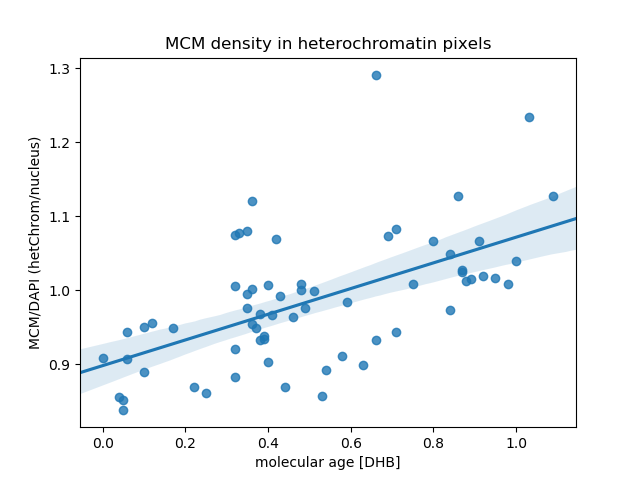

In [84]:
%matplotlib notebook

myDataSelnd['temp']=(myDataSelnd.hetChrom_gestalt_ch2/myDataSelnd.nucleus_Otsu_ch2)/(myDataSelnd.hetChrom_gestalt_ch3/myDataSelnd.nucleus_Otsu_ch3)
sn.regplot(x='mol_age_mod', y = 'temp', data=myDataSelnd.loc[((myDataSelnd.day!='d20190625') & (myDataSelnd.day!='d201907012') &
                                                           ['G1' in x for x in myDataSelnd.category]),:])
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
x=plt.title("MCM density in heterochromatin pixels")

In [85]:
# temp = (myDataSel.hetChrom_gestalt_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_gestalt_ch3/myDataSel.nucleus_Otsu_ch3)
x = np.array(myDataSelnd.mol_age_mod)
y = np.array(myDataSelnd.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.0662828123265457, intercept=0.9567568398317464, rvalue=0.27424943500064314, pvalue=0.0018077393973891106, stderr=0.020788401450981875)

## Manual

### deconvoled

<IPython.core.display.Javascript object>


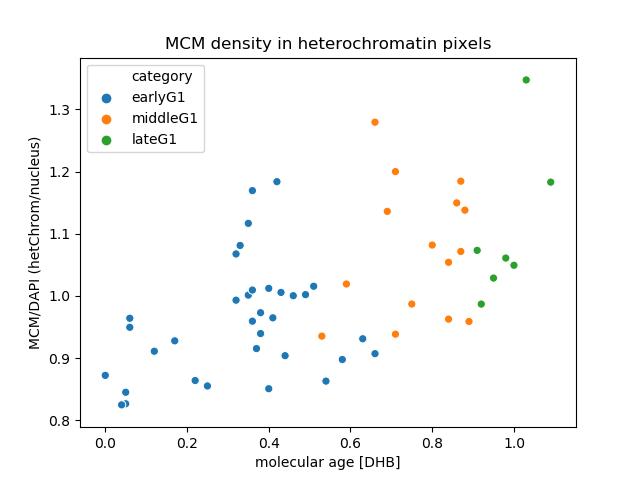

Text(0.5, 1.0, 'MCM density in heterochromatin pixels')

In [86]:
%matplotlib notebook

myDataSel['temp']=(myDataSel.hetChrom_manual_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_manual_ch3/myDataSel.nucleus_Otsu_ch3)
sn.scatterplot(x='mol_age_mod', y = 'temp', data=myDataSel.loc[((myDataSel.day!='d20190625') & (myDataSel.day!='d201907012') &
                                                           ['G1' in x for x in myDataSel.category]),:],hue='category')
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
plt.title("MCM density in heterochromatin pixels")

In [87]:
# temp = (myDataSel.hetChrom_manual_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_manual_ch3/myDataSel.nucleus_Otsu_ch3)
x = np.array(myDataSel.mol_age_mod)
y = np.array(myDataSel.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.08823682622483489, intercept=0.973826410464803, rvalue=0.23202042152896987, pvalue=0.011114535815735046, stderr=0.034199088060273254)

<IPython.core.display.Javascript object>


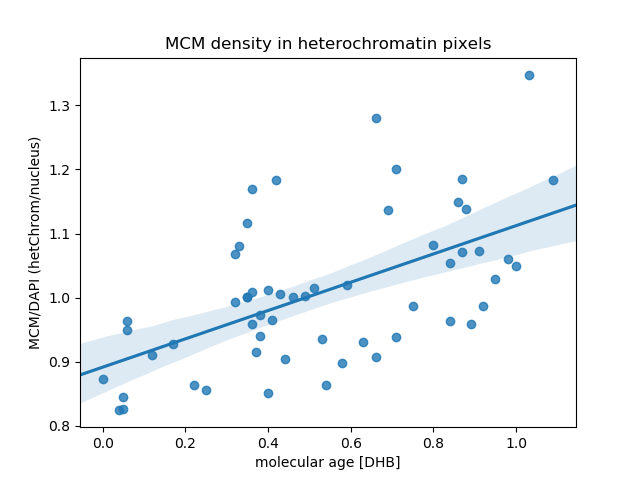

In [88]:
%matplotlib notebook

myDataSel['temp']=(myDataSel.hetChrom_manual_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_manual_ch3/myDataSel.nucleus_Otsu_ch3)
sn.regplot(x='mol_age_mod', y = 'temp', data=myDataSel.loc[((myDataSel.day!='d20190625') & (myDataSel.day!='d201907012') &
                                                           ['G1' in x for x in myDataSel.category]),:])
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
x=plt.title("MCM density in heterochromatin pixels")

In [89]:
# temp = (myDataSel.hetChrom_gestalt_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_gestalt_ch3/myDataSel.nucleus_Otsu_ch3)
x = np.array(myDataSel.mol_age_mod)
y = np.array(myDataSel.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.08823682622483489, intercept=0.973826410464803, rvalue=0.23202042152896987, pvalue=0.011114535815735046, stderr=0.034199088060273254)

### not deconvolved 

<IPython.core.display.Javascript object>


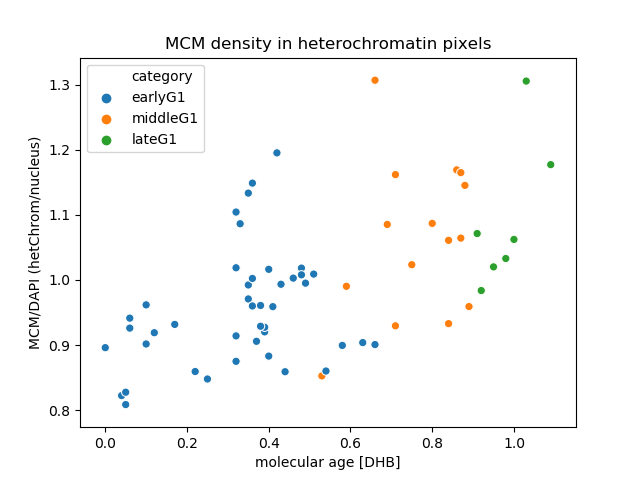

Text(0.5, 1.0, 'MCM density in heterochromatin pixels')

In [90]:
%matplotlib notebook

myDataSelnd['temp']=(myDataSelnd.hetChrom_manual_ch2/myDataSelnd.nucleus_Otsu_ch2)/(myDataSelnd.hetChrom_manual_ch3/myDataSelnd.nucleus_Otsu_ch3)
sn.scatterplot(x='mol_age_mod', y = 'temp', data=myDataSelnd.loc[((myDataSelnd.day!='d20190625') & (myDataSelnd.day!='d201907012') &
                                                           ['G1' in x for x in myDataSelnd.category]),:],hue='category')
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
plt.title("MCM density in heterochromatin pixels")

In [91]:
# temp = (myDataSelnd.hetChrom_manual_ch2/myDataSelnd.nucleus_Otsu_ch2)/(myDataSelnd.hetChrom_manual_ch3/myDataSelnd.nucleus_Otsu_ch3)
x = np.array(myDataSelnd.mol_age_mod)
y = np.array(myDataSelnd.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.08023913889731278, intercept=0.9588004957740642, rvalue=0.24178909288741704, pvalue=0.006169357576969471, stderr=0.028801392199500495)

<IPython.core.display.Javascript object>


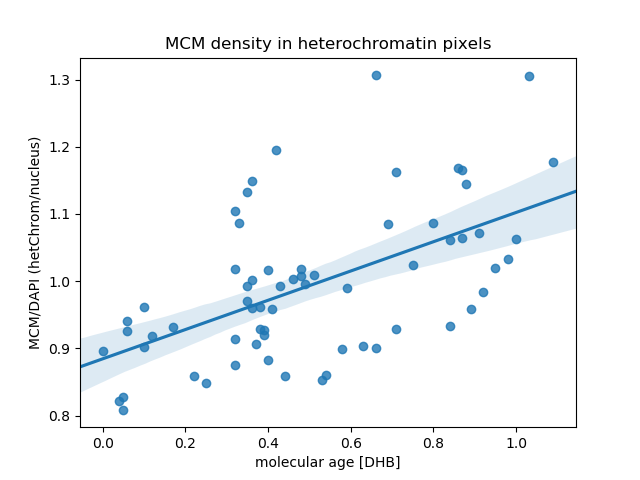

In [92]:
%matplotlib notebook

myDataSelnd['temp']=(myDataSelnd.hetChrom_manual_ch2/myDataSelnd.nucleus_Otsu_ch2)/(myDataSelnd.hetChrom_manual_ch3/myDataSelnd.nucleus_Otsu_ch3)
sn.regplot(x='mol_age_mod', y = 'temp', data=myDataSelnd.loc[((myDataSelnd.day!='d20190625') & (myDataSelnd.day!='d201907012') &
                                                           ['G1' in x for x in myDataSelnd.category]),:])
plt.ylabel("MCM/DAPI (hetChrom/nucleus)")
plt.xlabel("molecular age [DHB]")
x=plt.title("MCM density in heterochromatin pixels")

In [93]:
# temp = (myDataSel.hetChrom_gestalt_ch2/myDataSel.nucleus_Otsu_ch2)/(myDataSel.hetChrom_gestalt_ch3/myDataSel.nucleus_Otsu_ch3)
x = np.array(myDataSelnd.mol_age_mod)
y = np.array(myDataSelnd.temp)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)

LinregressResult(slope=0.08023913889731278, intercept=0.9588004957740642, rvalue=0.24178909288741704, pvalue=0.006169357576969471, stderr=0.028801392199500495)